In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-5x971o0t
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-5x971o0t
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=c2d570047d9d35e42771d14fc266ddf7f5522ef02c4563db99614274c16f59e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-0dpu4cul/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import os
import datetime
import random
import warnings
import numpy as np
import sys
import matplotlib.pyplot as plt

os.chdir('/content/drive/My Drive/GitHub Repositories')
baseDir = './Research Paper Contribution/Cascaded Model/Synthetic Data'

normal = np.load(os.path.join(baseDir, 'dataset', '0', 'images.npy'), mmap_mode = 'r')[:]
infected = np.load(os.path.join(baseDir, 'dataset','1', 'images.npy'), mmap_mode = 'r')[:]
print('Synthetic Data Class-0 : {}'.format(normal.shape))
print('Synthetic Data Class-1 : {}'.format(infected.shape))

Synthetic Data Class-0 : (500, 128, 128, 1)
Synthetic Data Class-1 : (500, 128, 128, 1)


**Generator with U-Net Architecture**                              
**Discriminator**                                                               
**Combined Network**

In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers import LeakyReLU
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
warnings.filterwarnings("ignore")

img_rows, img_columns, channels = 128, 128, 1

img_shape = (img_rows, img_columns, channels)

def Generator():
  inputs = Input(img_shape)
  conv1 = Conv2D(32, (4, 4), strides=2, padding='same')(inputs)   
  conv1 = LeakyReLU(alpha=0.2)(conv1)
  conv1 = InstanceNormalization()(conv1)

  
  conv2 = Conv2D(64, (4, 4), strides=2, padding='same')(conv1)   
  conv2 = LeakyReLU(alpha=0.2)(conv2)
  conv2 = InstanceNormalization()(conv2)
  
  conv3 = Conv2D(128, (4, 4), strides=2, padding='same')(conv2)  
  conv3 = LeakyReLU(alpha=0.2)(conv3)
  conv3 = InstanceNormalization()(conv3)

  conv4 = Conv2D(256, (4, 4), strides=2, padding='same')(conv3)   
  conv4 = LeakyReLU(alpha=0.2)(conv4)
  conv4 = InstanceNormalization()(conv4)

  
  Deconv4 = concatenate([Conv2DTranspose(128, (4, 4), strides=2, padding='same')(conv4), conv3], axis=-1)  # 64
  Deconv4 = InstanceNormalization()(Deconv4)
  Deconv4 = Dropout(0.2)(Deconv4)
  Deconv4 = Activation('relu')(Deconv4)
  
  Deconv3 = concatenate([Conv2DTranspose(64, (4, 4), strides=2, padding='same')(Deconv4), conv2], axis=-1)  # 64
  Deconv3 = InstanceNormalization()(Deconv3)
  Deconv3 = Dropout(0.2)(Deconv3)
  Deconv3 = Activation('relu')(Deconv3)

  Deconv2 = concatenate([Conv2DTranspose(32, (4, 4), strides=2, padding='same')(Deconv3), conv1], axis=-1)   # 128
  Deconv2 = InstanceNormalization()(Deconv2)
  Deconv2 = Dropout(0.2)(Deconv2)
  Deconv2 = Activation('relu')(Deconv2)

  Deconv1 = UpSampling2D(size=(2, 2))(Deconv2)   # 256
  Deconv1 = Conv2D(1, (4, 4), strides=1, padding='same')(Deconv1)
  outputs = Activation('tanh')(Deconv1)
  
  return Model(inputs=inputs, outputs=outputs)

def Discriminator():
  inputs = Input(img_shape)
  conv1 = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)   # 128
  conv1 = LeakyReLU(alpha=0.2)(conv1)
  conv1 = Dropout(0.2)(conv1)
  conv1 = InstanceNormalization()(conv1)

  
  conv2 = Conv2D(128, (4, 4), strides=2, padding='same')(conv1)   # 64
  conv2 = LeakyReLU(alpha=0.2)(conv2)
  conv2 = Dropout(0.2)(conv2)
  conv2 = InstanceNormalization()(conv2)
  
  conv3 = Conv2D(256, (4, 4), strides=2, padding='same')(conv2)   # 32
  conv3 = LeakyReLU(alpha=0.2)(conv3)
  conv3 = Dropout(0.2)(conv3)  
  conv3 = InstanceNormalization()(conv3)
  
  conv4 = Conv2D(512, (4, 4), strides=2, padding='same')(conv3)   # 16
  conv4 = LeakyReLU(alpha=0.2)(conv4)
  conv4 = Dropout(0.2)(conv4)  
  conv4 = InstanceNormalization()(conv4)
  
  outputs = Conv2D(1, (4, 4), strides=1, padding='same')(conv4)   # 4

  return Model(inputs=inputs, outputs=outputs)
  
# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Loss weights
lambda_cycle = 10.0                    # Cycle-consistency loss
lambda_id = 0.1 * lambda_cycle         # Identity loss
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminators
d_A = Discriminator()
print(d_A.summary())
d_B = Discriminator()
d_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
d_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Build the generators
g_AB = Generator()
print(g_AB.summary())

g_BA = Generator()

# Input images from both domains
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# Translate images to the other domain
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)

# Translate images back to original domain
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)

# Identity mapping of images
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# For the combined model we will only train the generators
d_A.trainable = False
d_B.trainable = False

# Discriminators determines validity of translated images
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# Combined model trains generators to fool discriminators
combined = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id])
combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1, 1, lambda_cycle, lambda_cycle, lambda_id, lambda_id], optimizer=optimizer)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
instance_normalization_23 (I (None, 64, 64, 64)        2         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 128)       0   

**Training and Testing on a specified Validation Data**

In [0]:
import os
import datetime
import random
import warnings
import numpy as np
import sys
import matplotlib.pyplot as plt


train_normal = normal[:490]
test_normal = normal[490:]
train_infected = infected[:490]
test_infected = infected[490:]
print('Train-0 : {} | Test-0: {}'.format(train_normal.shape, test_normal.shape))
print('Train-1 : {} | Test-1: {}'.format(train_infected.shape, test_infected.shape))

start_time = datetime.datetime.now()
epoches = 10
batch_size = 1
batches = int(min(train_normal.shape[0], train_infected.shape[0])/batch_size)
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

for epoch in range(epoches):
  epoch = epoch + 1
  dis_loss = []
  gen_loss = []
  print('Epoch: {}/{} | Batches: {}'.format(epoch, epoches, batches))
  for batch in range(batches):
    imgs_A = []
    imgs_B = []
    
    infected =  random.choice(train_infected)
    if np.random.random() > 0.5:
       infected = np.fliplr(infected)
    imgs_A.append(infected)

    normal = random.choice(train_normal)
    if np.random.random() > 0.5:
      normal = np.fliplr(normal)
    imgs_B.append(normal)
    
    imgs_A = np.array(imgs_A).reshape(-1, 128, 128, 1)
    imgs_B = np.array(imgs_B).reshape(-1, 128, 128, 1)
    
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)
        
    # Train the discriminators (original images = real / translated = Fake)
    dA_loss_real = d_A.train_on_batch(imgs_A, valid)
    dA_loss_fake = d_A.train_on_batch(fake_A, fake)
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
    
    dB_loss_real = d_B.train_on_batch(imgs_B, valid)
    dB_loss_fake = d_B.train_on_batch(fake_B, fake)
    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)
    
    # Total disciminator loss
    d_loss = 0.5 * np.add(dA_loss, dB_loss)
    dis_loss.append(d_loss)
    # ------------------
    #  Train Generators
    # ------------------
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B])
    elapsed_time = datetime.datetime.now() - start_time
    sys.stdout.write('\r[Batch {0}/{1}] [D loss: {2:.2f}, acc: {3:.2f}] [G loss: {4:.2f}, adv: {5:.2f}, recon: {6:.2f}, id: {7:.2f}] time: {8}'.format(batch+1, batches,
                       d_loss[0], 100*d_loss[1],  g_loss[0], np.mean(g_loss[1:3]), np.mean(g_loss[3:5]), np.mean(g_loss[5:6]), elapsed_time))
    
  folder= os.path.join(baseDir, 'saved models', 'Step1/Epoch_'+str(epoch))
  if not os.path.exists(folder):
    os.makedirs(folder)
  g_AB.save(folder + '/G_infected2normal.h5')
  g_BA.save(folder + '/G_normal2infected.h5')

  index = np.random.choice(test_infected.shape[0], 10, replace=False)  
  test_imgs_A = test_infected[index]
  gen_imgs_B = g_AB.predict(test_imgs_A)
  plt.figure(1, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('class:1 # {}' .format(i+1))
    plt.imshow(test_imgs_A[i, :, :, 0], cmap='gray')
  plt.figure(2, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('G-class:0 # {}' .format(i+1))
    plt.imshow(gen_imgs_B[i, :, :, 0], cmap='gray')
  plt.show()
  plt.close()

Output hidden; open in https://colab.research.google.com to view.

**Load the Best Saved Model and Generate Normal Images against Each Infected Image to get Pairs**

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









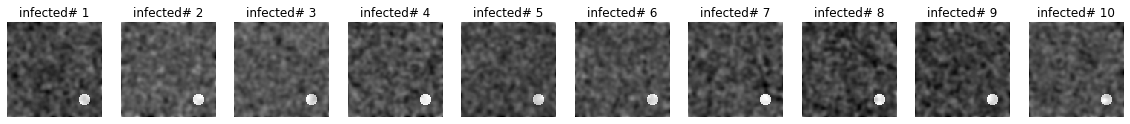

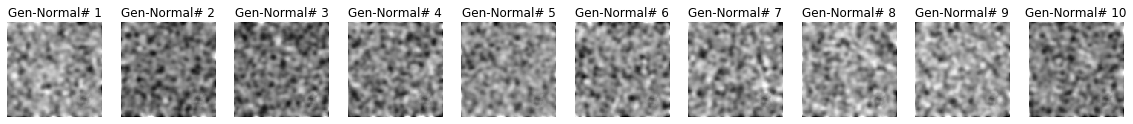

In [0]:
import os
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


os.chdir('/content/drive/My Drive/GitHub Repositories')
baseDir = './Research Paper Contribution/Cascaded Model/Synthetic Data'

infected = np.load(os.path.join(baseDir, 'dataset', '1', 'images.npy'), mmap_mode = 'r')[:]

def plotResults(infected, normal):
  plt.figure(1, figsize=(20,20))
  for i in range(infected.shape[0]):
    plt.subplot(1, infected.shape[0], i+1).set_title('infected# {}' .format(i+1))
    plt.imshow(infected[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize=(20,20))
  for i in range(normal.shape[0]):
    plt.subplot(1, normal.shape[0], i+1).set_title('Gen-Normal# {}' .format(i+1))
    plt.imshow(normal[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.show()
  plt.close()

G = load_model(os.path.join(baseDir, 'saved models', 'Step 1', 'Best Epoch Model', 'G_infected2normal.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})
normal = G.predict(infected)
plotResults(infected[:10], normal[:10])
np.save(os.path.join(baseDir, 'dataset', '0', 'generated-normal_images'), normal)
